## 목적


- 데이터 실험 결과를 어떻게 저장할 것인지
- 이 실험 결과들을 어떻게 필터링할 것인지
- 그 결과를 바탕으로 어떻게 시각화할 것인지

### 무엇을 저장해야 할까?

- args의 실험 설정 값
- epoch에 따른 train loss, validation loss, train accuracy, validation accuracy
- 최종 test loss, test accuracy

### 메모리 상의 변수에만 저장할 경우

프로그램이 충돌하거나 예기치 못한 문제로 종료될 경우, 데이터가 모두 사라진다.
- 이를 방지하기 위해 디스크에 실제 파일로 저장하여 예기치 못한 데이터 소실을 방지한다.

그럼 어떻게 파일 형태로 저장할까?
- JSON 사용

파일의 이름에 대한 중복을 방지하기 위해 Experiment의 이름과 Experiment에 사용된 Hyper Parameters 설정 값들의 Hash 값을 조합하여 파일 이름을 설정

## 각각의 Experiment에 대한 결과 저장을 위한 폴더 생성

In [1]:
!mkdir results

## 필요한 라이브러리 import

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy

## GPU 가용성 확인 및 연산 장치 결정

In [3]:
print(f"CUDA Available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")

CUDA Available: True
Current Device: cuda


## 랜덤 시드 고정 함수

In [4]:
import random
import numpy as np

def set_random_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)

## 데이터 준비

In [5]:
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(
  root="./data",
  train=True,
  download=True,
  transform=transform
)

trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])

testset = torchvision.datasets.CIFAR10(
  root="./data",
  train=False,
  download=True,
  transform=transform
)

partition = {
  "train": trainset,
  "val":valset,
  "test":testset
}

100%|██████████| 170M/170M [00:05<00:00, 30.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Model Architecture

In [6]:
class MLP(nn.Module):
  def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
    super(MLP, self).__init__()
    self.in_dim = in_dim
    self.out_dim = out_dim
    self.hid_dim = hid_dim
    self.n_layer = n_layer
    self.act = act
    self.dropout = dropout
    self.use_bn = use_bn
    self.use_xavier = use_xavier

    # Linear Layer 생성
    self.fc1 = nn.Linear(self.in_dim, self.hid_dim)

    self.linears = nn.ModuleList()
    self.bns = nn.ModuleList()
    for _ in range(self.n_layer - 1):
      self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
      if self.use_bn:
        self.bns.append(nn.BatchNorm1d(self.hid_dim))

    self.fc2 = nn.Linear(self.hid_dim, self.out_dim)

    # Activation Function 설정
    if self.act == "relu":
      self.act = nn.ReLU()
    elif self.act == "tanh":
      self.act == nn.Tanh()
    elif self.act == "sigmoid":
      self.act = nn.Sigmoid()
    else:
      raise ValueError("no valid activation function selected!")

    # Regularization Layer 생성
    self.dropout = nn.Dropout(self.dropout)
    if self.use_xavier:
      self.xavier_init()

  def forward(self, x):
    x = self.act(self.fc1(x))
    for i in range(len(self.linears)):
      x = self.act(self.linears[i](x))
      x = self.bns[i](x)
      x = self.dropout(x)
    x = self.fc2(x)
    return x

  def xavier_init(self):
    for linear in self.linears:
      nn.init.xavier_normal_(linear.weight)
      linear.bias.data.fill_(0.01)

## Train 함수

Model을 입력 받은 후 Train Dataset을 사용하여 Epoch 1회의 학습을 수행한다.

수행 이후의 학습된 Model과 Train Loss, Train Accuracy를 반환한다.

- Input
  - Model
  - DataLoaders
  - Optimizer
  - Loss Function
  - Hyper Parameters

- Output
  - Trained Model
  - Train Loss
  - Train Accuracy

In [7]:
def train(net, partition, optimizer, criterion, args):
  trainloader = torch.utils.data.DataLoader(partition["train"], batch_size=args.train_batch_size, shuffle=True, num_workers=2)

  # 학습 모드 활성화
  net.train()

  correct = 0
  total = 0
  train_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    optimizer.zero_grad()

    inputs, labels = data
    inputs = inputs.view(-1, 3072)
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = net(inputs)

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  train_loss = train_loss / len(trainloader)
  train_acc = 100 * correct / total
  return net, train_loss, train_acc

## Validation 함수

Model을 입력받은 후 Validation Dataset을 사용하여 성능을 측정한다.

수행 이후의 Validation Loss, Validation Accuracy를 반환한다.

- Input
  - Model
  - DataLoaders
  - Loss Function
  - Hyper Parameters

- Output
  - Validation Loss
  - Validation Accuracy

In [8]:
def validate(net, partition, criterion, args):
  valloader = torch.utils.data.DataLoader(partition["val"], batch_size=args.test_batch_size, shuffle=False, num_workers=2)

  # 평가 모드 활성화
  net.eval()

  correct = 0
  total = 0
  val_loss = 0
  with torch.no_grad():
    for data in valloader:
      images, labels = data
      images = images.view(-1, 3072)
      images = images.to(device)
      labels = labels.to(device)
      outputs = net(images)

      loss = criterion(outputs, labels)

      val_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(valloader)
    val_acc = 100 * correct / total
  return val_loss, val_acc

## Test 함수

Model을 입력받은 후 Test Dataset을 사용하여 성능을 측정한다.

수행 이후의 Test Accuracy를 반환한다.

- Input
  - Model
  - DataLoaders
  - Hyper Parameters

- Output
  - Test Accuracy

In [9]:
def test(net, partition, args):
  testloader = torch.utils.data.DataLoader(partition["test"], batch_size=args.test_batch_size, shuffle=False, num_workers=2)

  # 평가 모드 활성화
  net.eval()

  correct = 0
  total = 0
  with torch.no_grad():
    for data in testloader:
      images, labels = data
      images = images.view(-1, 3072)
      images = images.to(device)
      labels = labels.to(device)

      outputs = net(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
  return test_acc

## Experiment 함수

- 입력된 Hyper Parameter를 사용하여 새로운 Model을 구성한다.
- Train 및 Validation 과정을 거치며 종료 조건을 만족하게 될 경우 학습을 중단하고 Test 과정을 거쳐 성능 평가를 수행한다.

In [10]:
def experiment(partition, args):
  net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
  net.to(device)

  criterion = nn.CrossEntropyLoss()
  if args.optim == "SGD":
    optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
  elif args.optim == "RMSprop":
    optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
  elif args.optim == "Adam":
    optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
  else:
    raise ValueError("In-valid optimizer choice")

  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []

  for epoch in range(args.epoch):
    ts = time.time()
    net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
    val_loss, val_acc = validate(net, partition, criterion, args)
    te = time.time()

    # 각 Epoch에서의 성능을 기록
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch}, Acc(train/val): {train_acc:2.2f}/{val_acc:2.2f}, Loss(train/val) {train_loss:2.2f}/{val_loss:2.2f}. Took {te - ts:2.2f} sec")

  test_acc = test(net, partition, args)

  # 결과를 저장
  result = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accs": train_accs,
    "val_accs": val_accs,
    "train_acc": train_acc,
    "val_acc": val_acc,
    "test_acc": test_acc
  }
  return vars(args), result

## Experiment 결과 저장 및 관리

In [11]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd


# Experiment 설정 및 결과 저장
def save_exp_result(setting, result):
  # 저장하고 싶지 않은 설정값을 제외
  del setting["epoch"]
  del setting["test_batch_size"]

  # 고유한 파일명 생성
  exp_name = setting["exp_name"]
  hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
  filename = f"./results/{exp_name}-{hash_key}.json"

  # Hyper Parameter 설정값과 Experiment 결과값을 하나의 Dictionary로 병합
  result.update(setting)

  # 파일에 저장
  with open(filename, "w") as f:
    json.dump(result, f)


# Experiment 설정 및 결과 불러오기
def load_exp_result(exp_name):
  dir_path = "./results"
  filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if ".json" in f]
  list_result = []
  for filename in filenames:
    if exp_name in filename:
      with open(join(dir_path, filename), "r") as infile:
        results = json.load(infile)
        list_result.append(results)

  # DataFrame 형태로 변환
  df = pd.DataFrame(list_result)

  return df

## Experiment 수행

- 여러 Experiment를 수행
- 여러 종류의 Hyper Parameter 조합을 시도해보며 각 Experiment에 대한 결과를 저장

목적: 가장 좋은 Hyper Parameter 조합 찾기

In [12]:
# 결과의 재현성을 위한 랜덤 시드 고정
set_random_seed(123)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

# Experiment의 이름을 설정
# n_layer와 hid_dim의 값의 적절한 조합을 찾는 Experiment
args.exp_name = "exp1_n_layer_hid_dim"

# 모델의 용량 설정
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = "relu"

# 정규화 설정
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# Optimizer 및 학습 설정
args.optim = "RMSprop" # RMSprop, SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10
args.train_batch_size = 256
args.test_batch_size = 1024



# Hyper Parameter 조합 생성
# n_layer와 hid_dim의 값을 각각 [1, 2, 3]과 [500, 300]으로 변경하며 각 조합에 대한 Experiment를 수행
name_var1 = "n_layer"
name_var2 = "hid_dim"
list_var1 = [1, 2, 3]
list_var2 = [500, 300]

for var1 in list_var1:
  for var2 in list_var2:
    setattr(args, name_var1, var1)
    setattr(args, name_var2, var2)
    print(args)

    # Experiment 수행
    setting, result = experiment(partition, deepcopy(args))

    # Experiment에 대한 설정 및 결과 저장
    save_exp_result(setting, result)

Namespace(exp_name='exp1_n_layer_hid_dim', in_dim=3072, out_dim=10, hid_dim=500, act='relu', dropout=0.2, use_bn=True, l2=1e-05, use_xavier=True, optim='RMSprop', lr=0.0015, epoch=10, train_batch_size=256, test_batch_size=1024, n_layer=1)
Epoch 0, Acc(train/val): 38.08/36.73, Loss(train/val) 2.52/2.00. Took 11.88 sec
Epoch 1, Acc(train/val): 45.93/41.15, Loss(train/val) 1.57/1.84. Took 10.91 sec
Epoch 2, Acc(train/val): 48.80/42.85, Loss(train/val) 1.49/1.71. Took 10.71 sec
Epoch 3, Acc(train/val): 51.22/37.75, Loss(train/val) 1.43/2.17. Took 11.32 sec
Epoch 4, Acc(train/val): 53.16/40.65, Loss(train/val) 1.38/1.94. Took 11.52 sec
Epoch 5, Acc(train/val): 55.13/45.74, Loss(train/val) 1.32/1.70. Took 11.31 sec
Epoch 6, Acc(train/val): 56.61/45.30, Loss(train/val) 1.28/1.68. Took 12.74 sec
Epoch 7, Acc(train/val): 58.44/43.86, Loss(train/val) 1.23/2.01. Took 11.09 sec
Epoch 8, Acc(train/val): 60.27/41.22, Loss(train/val) 1.18/2.17. Took 11.01 sec
Epoch 9, Acc(train/val): 61.59/50.11, Los

## 시각화

- Seaborn 및 Matplotlib를 사용하여 각각의 Experiment에 대한 결과를 시각화

<Axes: xlabel='n_layer', ylabel='test_acc'>

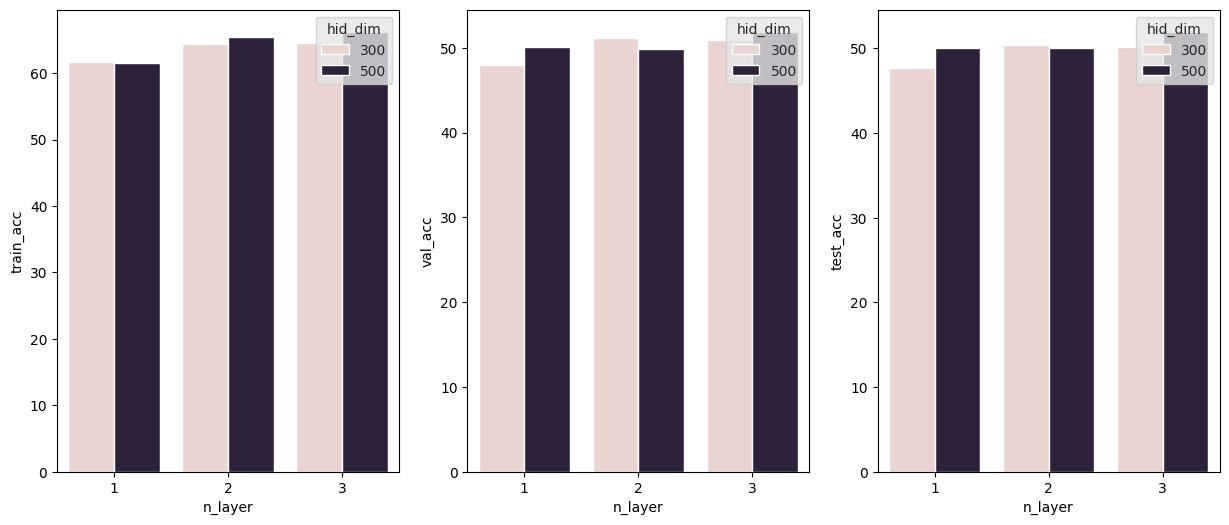

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# "exp1" 이름의 Experiment 설정 및 결과 불러오기
df = load_exp_result("exp1")

# 총 3개의 Plot을 출력할 수 있는 공간 생성
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)

sns.set_style("darkgrid", {"axes.facecolor": "0.9"})

# x축을 n_layer, y축을 train_acc, 색상을 hid_dim에 따라 표시한 Bar Plot
sns.barplot(x="n_layer", y="train_acc", hue="hid_dim", data=df, ax=ax[0])

# x축을 n_layer, y축을 val_acc, 색상을 hid_dim에 따라 표시한 Bar Plot
sns.barplot(x="n_layer", y="val_acc", hue="hid_dim", data=df, ax=ax[1])

# x축을 n_layer, y축을 test_acc, 색상을 hid_dim에 따라 표시한 Bar Plot
sns.barplot(x="n_layer", y="test_acc", hue="hid_dim", data=df, ax=ax[2])

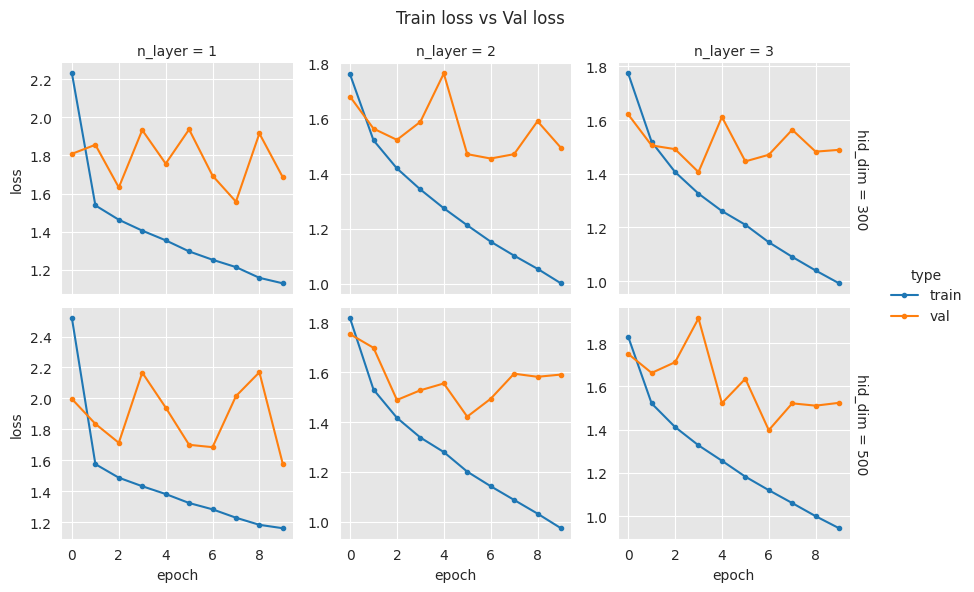

In [14]:
var1 = "n_layer"
var2 = "hid_dim"

df = load_exp_result("exp1")

# n_layer Column에서의 unique한 값 종류를 추출 (n_layer에서 찾을 수 있는 값들의 종류)
list_v1 = df[var1].unique()

# hid_dim Column에서의 unique한 값 종류를 추출 (hid_dim에서 찾을 수 있는 값들의 종류)
list_v2 = df[var2].unique()

list_data = []

# n_layer에서 찾을 수 있는 각각의 값들마다 수행
for value1 in list_v1:
  # hid_dim에서 찾을 수 있는 각각의 값들마다
  for value2 in list_v2:
    # n_layer의 값이 value1인 행들을 추출
    row = df.loc[df[var1] == value1]
    # hid_dim의 값이 value2인 행들을 추출
    row = row.loc[df[var2] == value2]
    # 최종적으로 선택된 행은 n_layer의 값이 value1이고 hid_dim의 값이 value2인 행

    # 선택된 행 내부의 train_loss 기록을 추출
    train_losses = list(row.train_losses)[0]

    # 선택된 행 내부의 val_loss 기록을 추출
    val_losses = list(row.val_losses)[0]

    # 각 epoch에서의 train_loss 값을 기준으로 반복
    for epoch, train_loss in enumerate(train_losses):
      list_data.append({
        "type": "train",
        "loss": train_loss,
        "epoch": epoch,
        var1: value1,
        var2: value2
      })

    # 각 epoch에서의 val_loss 값을 기준으로 반복
    for epoch, val_loss in enumerate(val_losses):
      list_data.append({
        "type": "val",
        "loss": val_loss,
        "epoch": epoch,
        var1: value1,
        var2: value2
      })

df = pd.DataFrame(list_data)

# 여러 Plot을 표시하기 위한 Grid를 생성
# 가로는 var1(n_layer) 값으로 구분 표시, 세로는 var2(hid_dim) 값으로 구분, 색상은 type을 기준으로 설정
g = sns.FacetGrid(df, row=var2, col=var1, hue="type", margin_titles=True, sharey=False)
# 가로는 epoch 값, 세로는 loss 값을 기준으로 각각의 Plot 생성
g = g.map(plt.plot, "epoch", "loss", marker=".")

g.add_legend()
g.fig.suptitle("Train loss vs Val loss")

plt.subplots_adjust(top=0.89)

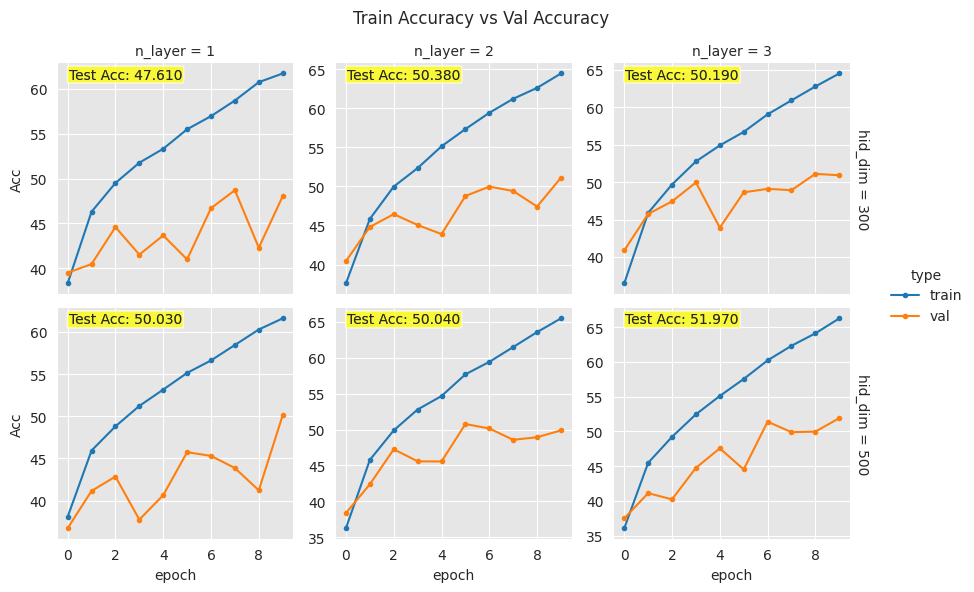

In [15]:
var1 = "n_layer"
var2 = "hid_dim"

df = load_exp_result("exp1")

# n_layer Column에서의 unique한 값 종류를 추출 (n_layer에서 찾을 수 있는 값들의 종류)
list_v1 = df[var1].unique()

# hid_dim Column에서의 unique한 값 종류를 추출 (hid_dim에서 찾을 수 있는 값들의 종류)
list_v2 = df[var2].unique()

list_data = []

# n_layer에서 찾을 수 있는 각각의 값들마다 수행
for value1 in list_v1:
  # hid_dim에서 찾을 수 있는 각각의 값들마다
  for value2 in list_v2:
    # n_layer의 값이 value1인 행들을 추출
    row = df.loc[df[var1] == value1]
    # hid_dim의 값이 value2인 행들을 추출
    row = row.loc[df[var2] == value2]
    # 최종적으로 선택된 행은 n_layer의 값이 value1이고 hid_dim의 값이 value2인 행

    # 선택된 행 내부의 train_acc 기록을 추출
    train_accs = list(row.train_accs)[0]

    # 선택된 행 내부의 val_acc 기록을 추출
    val_accs = list(row.val_accs)[0]

    # 선택된 행 내부의 test_acc 기록을 추출
    test_acc = list(row.test_acc)[0]

    # 각 epoch에서의 train_acc 값을 기준으로 반복
    for epoch, train_acc in enumerate(train_accs):
      list_data.append({
        "type": "train",
        "Acc": train_acc,
        "test_acc": test_acc,
        "epoch": epoch,
        var1: value1,
        var2: value2
      })

    # 각 epoch에서의 val_acc 값을 기준으로 반복
    for epoch, val_acc in enumerate(val_accs):
      list_data.append({
        "type": "val",
        "Acc": val_acc,
        "test_acc": test_acc,
        "epoch": epoch,
        var1: value1,
        var2: value2
      })

df = pd.DataFrame(list_data)

# 여러 Plot을 표시하기 위한 Grid를 생성
# 가로는 var1(n_layer) 값으로 구분 표시, 세로는 var2(hid_dim) 값으로 구분, 색상은 type을 기준으로 설정
g = sns.FacetGrid(df, row=var2, col=var1, hue="type", margin_titles=True, sharey=False)
# 가로는 epoch 값, 세로는 acc 값을 기준으로 각각의 Plot 생성
g = g.map(plt.plot, "epoch", "Acc", marker=".")

def show_acc(x, y, metric, **kwargs):
  plt.scatter(x, y, alpha=0.3, s=1)
  metric = f"Test Acc: {list(metric.values)[0]:1.3f}"
  plt.text(0.05, 0.95, metric, horizontalalignment="left", verticalalignment="center", transform=plt.gca().transAxes, bbox=dict(facecolor="yellow", alpha=0.5, boxstyle="round,pad=0.1"))

# 각각의 Plot에 Label 표시
g = g.map(show_acc, "epoch", "Acc", "test_acc")

g.add_legend()
g.fig.suptitle("Train Accuracy vs Val Accuracy")

plt.subplots_adjust(top=0.89)

## 평가

### 여러 Experiment의 결과를 바탕으로 적절한 Hyper Parameter들의 값과 조합을 적절히 선택한다.